The main goal of this notebook is to explore SV simulated outputs
from the SV data challenge `svdc2019c`

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from astropy.table import Table
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask
from collections import Counter

%matplotlib inline

First some environment definitions

In [73]:
def get_assigned_covered(tiles, targets, outdir):
    assigned_ids = list()
    covered_ids = list()
    for tileid in tiles['TILEID']:
        tilefile = '{}/tile-{:06d}.fits'.format(outdir, tileid)
        assignments = Table.read(tilefile, 'FIBERASSIGN')
        assigned_ids.extend(assignments['TARGETID'])

        #- Note: a single target could be covered by more than one fiber on the same
        #- tile, but it still can only be assigned once, so use np.unique() per tile
        #- to not double count those cases
        potential = Table.read(tilefile, 'POTENTIAL_ASSIGNMENTS')
        covered_ids.extend(np.unique(potential['TARGETID']))

    #- Trim to just science targets (i.e. not SKY, not non-science STDSTAR)
    assigned_ids = np.array(assigned_ids)
    ii = np.in1d(assigned_ids, targets['TARGETID'])
    assigned_ids = assigned_ids[ii]

    covered_ids = np.array(covered_ids)
    ii = np.in1d(covered_ids, targets['TARGETID'])
    covered_ids = covered_ids[ii]

    return assigned_ids, covered_ids

#- Do a bit of counting magic to include targets that were never assigned or covered
def count_coverage(ids, targets):
    c = Counter(ids)
    c.update(targets['TARGETID'])
    count = np.array(list(c.values())) - 1
    return count

def count_coverage_per_class(tiles, targets, outdir):
    assigned_desi_mask = list()
    assigned_bgs_mask = list()
    assigned_mws_mask = list()
    covered_desi_mask = list()
    covered_bgs_mask = list()
    covered_mws_mask = list()
    for tileid in tiles['TILEID']:
        print('processing', tileid)
        tilefile = '{}/tile-{:06d}.fits'.format(outdir, tileid)
        assignments = Table.read(tilefile, 'FIBERASSIGN')
        assigned_ids = assignments['TARGETID']
        ii = np.in1d(targets['TARGETID'], assigned_ids)
        assigned_desi_mask.extend(targets['SV1_DESI_TARGET'][ii])
        assigned_bgs_mask.extend(targets['SV1_BGS_TARGET'][ii])
        assigned_mws_mask.extend(targets['SV1_MWS_TARGET'][ii])

        #- Note: a single target could be covered by more than one fiber on the same
        #- tile, but it still can only be assigned once, so use np.unique() per tile
        #- to not double count those cases
        potential = Table.read(tilefile, 'POTENTIAL_ASSIGNMENTS')
        covered_ids = np.unique(potential['TARGETID'])
        ii = np.in1d(targets['TARGETID'], covered_ids)
        covered_desi_mask.extend(targets['SV1_DESI_TARGET'][ii])
        covered_bgs_mask.extend(targets['SV1_BGS_TARGET'][ii])
        covered_mws_mask.extend(targets['SV1_MWS_TARGET'][ii])
        
    results = dict()
    results['assigned_desi_mask'] = assigned_desi_mask
    results['assigned_bgs_mask'] = assigned_bgs_mask
    results['assigned_mws_mask'] = assigned_mws_mask
    results['covered_desi_mask'] = covered_desi_mask
    results['covered_bgs_mask'] = covered_bgs_mask
    results['covered_mws_mask'] = covered_mws_mask
    
    return results
  
    
#    desi_classes_in_assignment = []
#    bgs_classes_in_assignment = []
#    mws_classes_in_assignment = []

#    assigned = targets['TARGETID']==ids
#    for i in range(n_assignments):
#        target
#        desi_classes_in_assignment.extend(desi_mask.names(assignments['SV1_DESI_TARGET'][i]))
#    bgs_classes_in_assignment.extend(bgs_mask.names(assignments['SV1_BGS_TARGET'][i]))
#    mws_classes_in_assignment.extend(mws_mask.names(assignments['SV1_MWS_TARGET'][i]))
##    c = Counter(ids)
 #   c.update(targets['TARGETID'])
 #   count = np.array(list(c.values())) - 1
 #   return count

def summary_SV(SV_program='SV_BGS'):
    sv_main_dir = '/global/cscratch1/sd/mjwilson/svdc2019c/' 
    fiberassign_sub_dir = 'fiberassign/{}/'.format(SV_program)
    fib_dir = os.path.join(sv_main_dir, fiberassign_sub_dir)
    
    # Read the input catalog data
    mtl_file = Table.read(os.path.join(sv_main_dir, 'targets', 'mtl-{}.fits'.format(SV_program)))
    
    # Make a list of all available tiles
    tile_names = glob.glob(fib_dir+"/tile*.fits")
    print(fib_dir)
    n_tiles = len(tile_names)
    print('Total number of tiles {}'.format(n_tiles))
    
    # read all the assigned targets
    assignments = list()
    for tilefile in tile_names:
        assignments.append(Table.read(tilefile, 'FIBERASSIGN'))
    assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
    
    
    # count the number of times that a target was available and the times it got a fiber
    tiles = Table.read("{}/survey/{}-tiles.fits".format(sv_main_dir, SV_program))
    assigned_ids, covered_ids = get_assigned_covered(tiles, mtl_file, fib_dir)
    assigned_count = count_coverage(assigned_ids, mtl_file)
    covered_count = count_coverage(covered_ids, mtl_file)
    
    #count the number of targets of a given class was assigned
    #count_coverage_per_class(tiles, mtl_file, fib_dir)
    
    plt.figure(figsize=(16,8))

    #plot the coverage on the sky
    plt.subplot(2,2,1)
    isAssigned = np.in1d(mtl_file['TARGETID'], assigned_targetids)
    plt.plot(mtl_file['RA'][isAssigned], mtl_file['DEC'][isAssigned], 'k,')
    plt.title('Targets assigned to fibers. Program: {}. N_tiles: {}'.format(SV_program, n_tiles))
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    # plot_tiles(tiles)
    
    plt.subplot(2,2,2)
    plt.hist(assigned_count, 11, (-0.5, 10.5), rwidth=0.8, label=SV_program)
    plt.xticks(np.arange(0,11))
    plt.xlabel('number of times assigned')
    plt.legend()

    plt.subplot(2,2,4)
    plt.hist(covered_count, 11, (-0.5, 10.5), rwidth=0.8, label=SV_program)
    plt.xticks(np.arange(0,11))
    plt.xlabel('number of times covered')
    plt.legend()

    plt.tight_layout()

In [83]:
SV_program = 'SV_QSO'
sv_main_dir = '/global/cscratch1/sd/mjwilson/svdc2019c/' 
fiberassign_sub_dir = 'fiberassign/{}/'.format(SV_program)
fib_dir = os.path.join(sv_main_dir, fiberassign_sub_dir)
    
# Read the input catalog data
mtl_file = Table.read(os.path.join(sv_main_dir, 'targets', 'mtl-{}.fits'.format(SV_program)))
tiles = Table.read("{}/survey/{}-tiles.fits".format(sv_main_dir, SV_program))
results = count_coverage_per_class(tiles, mtl_file, fib_dir)

processing 72003
processing 72004
processing 72005
processing 72012
processing 72013
processing 72015


['QSO -- QSO_NORTH', 'QSO -- LRG_SOUTH -- ELG_SOUTH', 'QSO -- ELG_SOUTH', 'QSO -- ELG_NORTH -- QSO_NORTH', 'STD_FAINT -- STD_BRIGHT -- MWS_ANY', 'STD_FAINT -- MWS_ANY', 'QSO -- QSO_NORTH -- QSO_SOUTH', 'QSO -- ELG_NORTH', 'QSO -- QSO_SOUTH', 'QSO -- LRG_SOUTH', 'QSO -- ELG_NORTH -- QSO_SOUTH', 'QSO -- ELG_NORTH -- QSO_NORTH -- QSO_SOUTH', 'QSO -- ELG_SOUTH -- QSO_SOUTH', 'STD_WD -- MWS_ANY', 'STD_FAINT -- STD_BRIGHT', 'QSO -- LRG_SOUTH -- ELG_SOUTH -- QSO_SOUTH']
[2102 2368 1342 8312 1626  794  202 4994   48  548    1  118   74   74   22
    1]


<Container object of 16 artists>

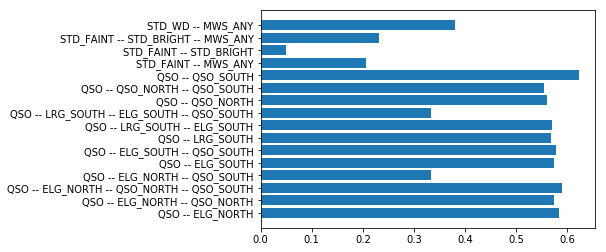

In [105]:
a_desi = Counter(results['assigned_desi_mask'])
c_desi = Counter(results['covered_desi_mask'])
target_names = dict()
for v, k in zip(a_desi.values(), a_desi.keys()):
    name = ' -- '.join(desi_mask.names(k))
    n_assigned = v
    n_covered = c_desi[k]
    target_names[name] = [n_assigned, n_covered] 
    #print(name, n_assigned, n_covered)
#print(names)
print(list(target_names.keys()))
values = np.array(list(target_names.values()))
print(values[:,0])
plt.barh(list(target_names.keys()), values[:,0]/values[:,1])

/global/cscratch1/sd/mjwilson/svdc2019c/fiberassign/SV_QSO/
Total number of tiles 6


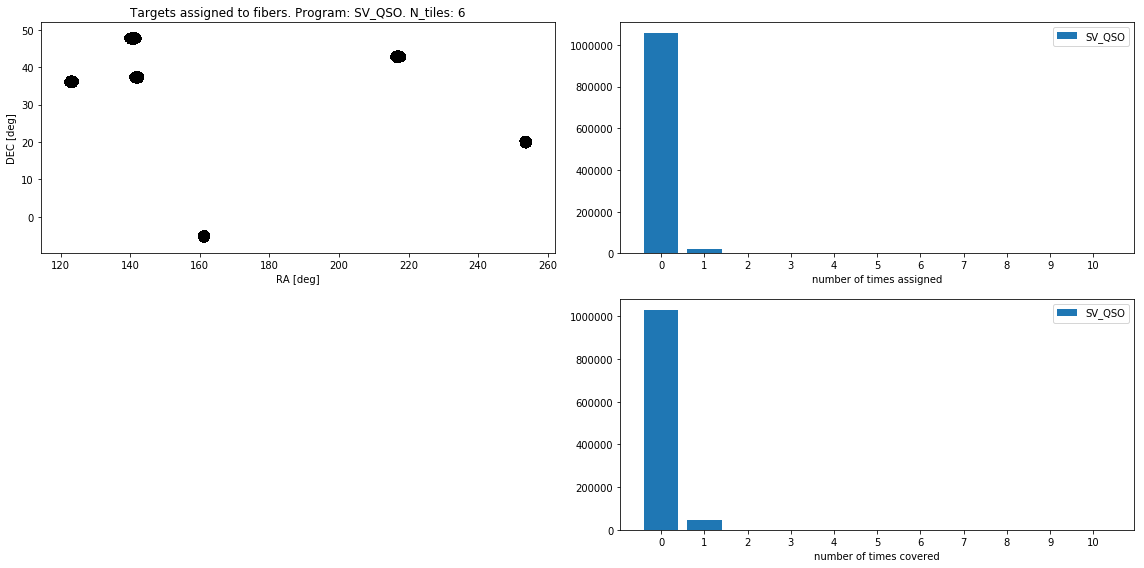

In [85]:
summary_SV(SV_program='SV_QSO')

/global/cscratch1/sd/mjwilson/svdc2019c/fiberassign/SV_ELG/
Total number of tiles 14


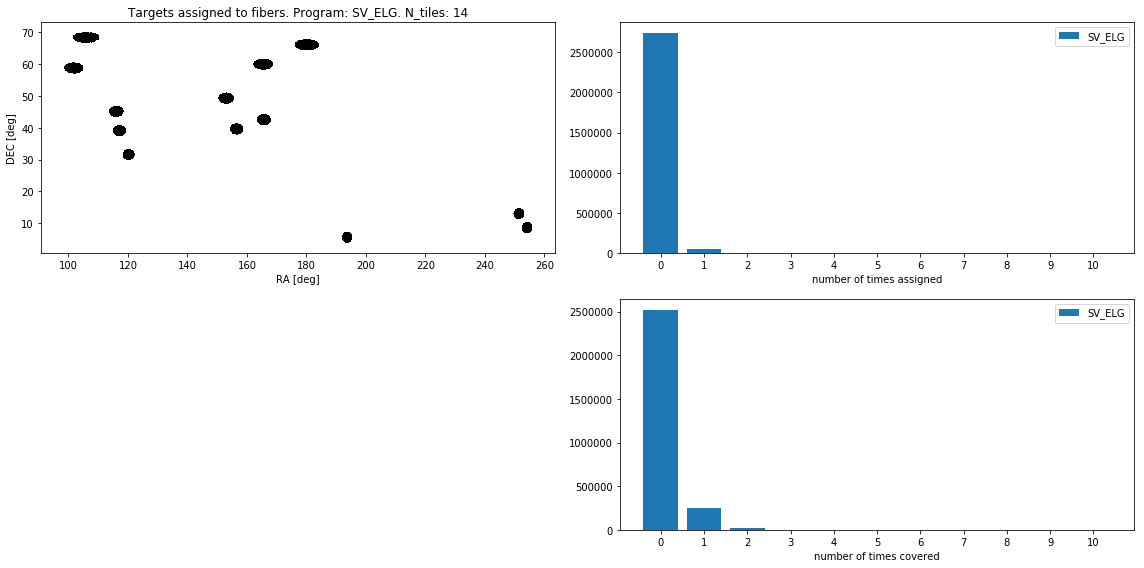

In [27]:
summary_SV(SV_program='SV_ELG')

/global/cscratch1/sd/mjwilson/svdc2019c/fiberassign/SV_MWS/
Total number of tiles 24


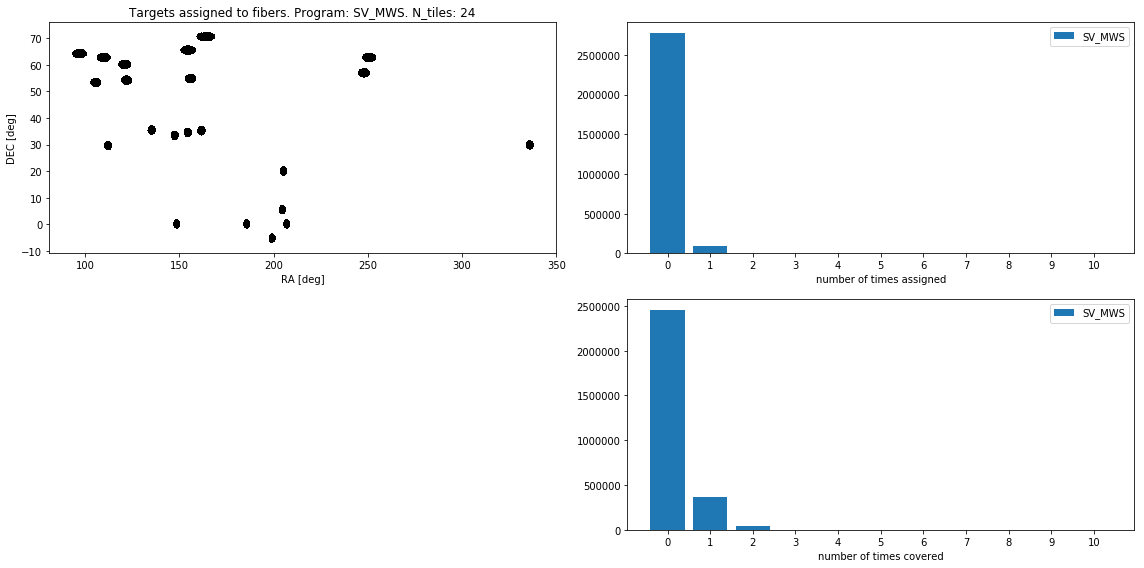

In [28]:
summary_SV(SV_program='SV_MWS')

/global/cscratch1/sd/mjwilson/svdc2019c/fiberassign/SV_BGS/


Total number of tiles 28


Explore the first tile.

Find the kind of samples present in the assigned fibers

In [8]:
tile_id = 0 
tilefile = tile_names[0]
assignments = Table.read(tilefile, 'FIBERASSIGN')
potential = Table.read(tilefile, 'POTENTIAL_ASSIGNMENTS')

n_assignments = len(assignments)

In [9]:
desi_classes_in_assignment = []
bgs_classes_in_assignment = []
mws_classes_in_assignment = []

for i in range(n_assignments):
    desi_classes_in_assignment.extend(desi_mask.names(assignments['SV1_DESI_TARGET'][i]))
    bgs_classes_in_assignment.extend(bgs_mask.names(assignments['SV1_BGS_TARGET'][i]))
    mws_classes_in_assignment.extend(mws_mask.names(assignments['SV1_MWS_TARGET'][i]))

In [10]:
print(Counter(desi_classes_in_assignment))
print(Counter(bgs_classes_in_assignment))
print(Counter(mws_classes_in_assignment))

Counter({'BGS_ANY': 3990, 'SKY': 801, 'MWS_ANY': 175, 'STD_BRIGHT': 160, 'STD_FAINT': 137, 'STD_WD': 40})
Counter({'BGS_BRIGHT': 3680, 'BGS_FAINT': 244, 'BGS_FAINT_EXT': 66, 'BGS_FIBMAG': 11})
Counter({'MWS_MAIN_BLUE': 148, 'MWS_WD': 40, 'MWS_NEARBY': 5})


Find the samples that were available to the fibers

In [11]:
desi_classes_in_potential = []
bgs_classes_in_potential = []
mws_classes_in_potential = []

ii = np.in1d(mtl_bgs['TARGETID'], potential['TARGETID'])
mtl_bgs_available = mtl_bgs[ii]
print(len(mtl_bgs_available))
for t in mtl_bgs_available[['SV1_DESI_TARGET', 'SV1_BGS_TARGET','SV1_MWS_TARGET']]:
    desi_classes_in_potential.extend(desi_mask.names(t['SV1_DESI_TARGET']))
    bgs_classes_in_potential.extend(bgs_mask.names(t['SV1_BGS_TARGET']))
    mws_classes_in_potential.extend(mws_mask.names(t['SV1_MWS_TARGET']))

19240


In [12]:
print(Counter(desi_classes_in_potential))
print(Counter(bgs_classes_in_potential))
print(Counter(mws_classes_in_potential))

Counter({'BGS_ANY': 17798, 'STD_BRIGHT': 1401, 'STD_FAINT': 943, 'MWS_ANY': 923, 'STD_WD': 41})
Counter({'BGS_FAINT': 8093, 'BGS_BRIGHT': 7835, 'BGS_FAINT_EXT': 1870, 'BGS_FIBMAG': 263})
Counter({'MWS_MAIN_BLUE': 889, 'MWS_WD': 41, 'MWS_NEARBY': 5})


In [13]:
assignments = list()
for tilefile in tile_names:
    assignments.append(Table.read(tilefile, 'FIBERASSIGN'))

In [15]:
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(mtl_bgs['TARGETID'], assigned_targetids)

Text(0.5,1,'Targets assigned to fibers')

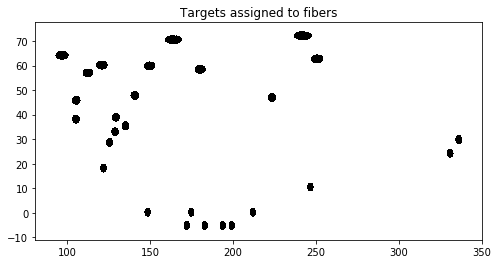

In [16]:
plt.figure(figsize=(8,4))
plt.plot(mtl_bgs['RA'][isAssigned], mtl_bgs['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
# plot_tiles(tiles)

In [24]:
def get_assigned_covered(tiles, targets, outdir):
    assigned_ids = list()
    covered_ids = list()
    for tileid in tiles['TILEID']:
        tilefile = '{}/tile-{:06d}.fits'.format(outdir, tileid)
        assignments = Table.read(tilefile, 'FIBERASSIGN')
        assigned_ids.extend(assignments['TARGETID'])

        #- Note: a single target could be covered by more than one fiber on the same
        #- tile, but it still can only be assigned once, so use np.unique() per tile
        #- to not double count those cases
        potential = Table.read(tilefile, 'POTENTIAL_ASSIGNMENTS')
        covered_ids.extend(np.unique(potential['TARGETID']))

    #- Trim to just science targets (i.e. not SKY, not non-science STDSTAR)
    assigned_ids = np.array(assigned_ids)
    ii = np.in1d(assigned_ids, targets['TARGETID'])
    assigned_ids = assigned_ids[ii]

    covered_ids = np.array(covered_ids)
    ii = np.in1d(covered_ids, targets['TARGETID'])
    covered_ids = covered_ids[ii]

    return assigned_ids, covered_ids

#- Do a bit of counting magic to include targets that were never assigned or covered
def count_coverage(ids, targets):
    c = Counter(ids)
    c.update(targets['TARGETID'])
    count = np.array(list(c.values())) - 1
    return count

In [25]:
tiles = Table.read("/global/cscratch1/sd/mjwilson/svdc2019c/survey/SV_BGS-tiles.fits")

In [26]:
assigned_ids, covered_ids = get_assigned_covered(tiles, mtl_bgs, fib_dir)
assigned_count = count_coverage(assigned_ids, mtl_bgs)
covered_count = count_coverage(covered_ids, mtl_bgs)

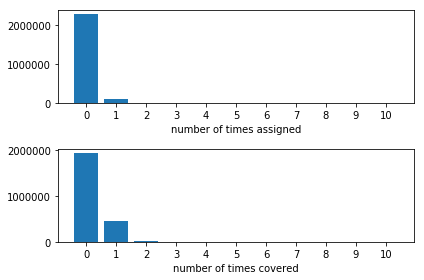

In [27]:
plt.subplot(211)
plt.hist(assigned_count, 11, (-0.5, 10.5), rwidth=0.8)
plt.xticks(np.arange(0,11))
plt.xlabel('number of times assigned')

plt.subplot(212)
plt.hist(covered_count, 11, (-0.5, 10.5), rwidth=0.8)
plt.xticks(np.arange(0,11))
plt.xlabel('number of times covered')

plt.tight_layout()